<a href="https://colab.research.google.com/github/Redwoods/pdm/blob/main/project/dogsNcats/dogsNcats_DL1_Daug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# dogsNcats
- ## Data Augmentation using ImageDataGenerator

In [1]:
# Down PetImages.zip from Google drive
!gdown https://drive.google.com/uc?id=1VEs5Hz2iThTqP_mRoxQgl8PrZVjwszod

Downloading...
From: https://drive.google.com/uc?id=1VEs5Hz2iThTqP_mRoxQgl8PrZVjwszod
To: /content/PetImages.zip
100% 70.4M/70.4M [00:00<00:00, 282MB/s]


In [ ]:
!unzip PetImages.zip -d PetImages
# !unzip -q PetImages.zip -d PetImages

In [3]:
import os
path = 'PetImages'
# 서브 디렉토리별 파일 개수 출력
for root, subdirs, files in os.walk(path):
    if len(files) > 0:
        print(root, len(files))

PetImages 1
PetImages/train 1
PetImages/train/cat 1000
PetImages/train/dog 1000
PetImages/test/cat 100
PetImages/test/dog 100


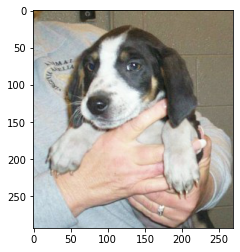

In [6]:
import matplotlib.pyplot as plt 
from matplotlib.image import imread
from tensorflow.keras import models, layers

# sample image
image = imread('PetImages/train/dog/10.jpg')
image.shape
plt.imshow(image)
plt.show()

## Data Augmentation

In [7]:
train_dir = './PetImages/train'
test_dir = './PetImages/test'

#### Data augmentation
# https://machinelearningmastery.com/image-augmentation-deep-learning-keras/
#
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,                      
    target_size=(128, 128), # (180,180)
    batch_size=20,          # 32,...
    class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=20,
    class_mode = 'binary')

# Inspect train_generator
print(train_generator)
# <keras.preprocessing.image.DirectoryIterator at 0x1ab237d6880>

Found 2000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [8]:
len(train_generator),len(test_generator)

(100, 10)

### Visualize data from data generator

(20, 128, 128, 3)
<class 'numpy.ndarray'>
[1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


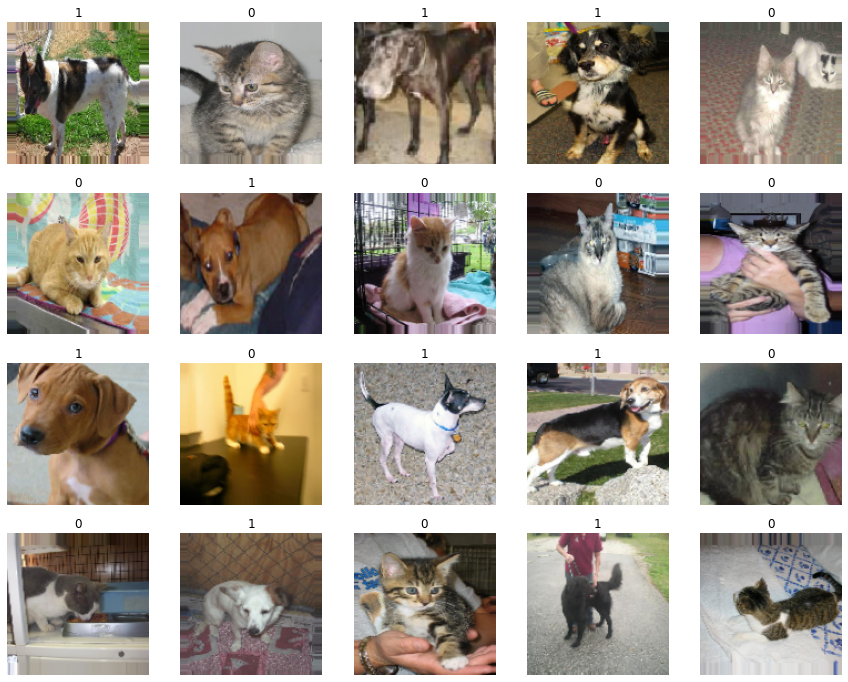

In [9]:
#
# Visualize data from data generator
# 1. Extract one batch
for x_data, t_data in train_generator:
    print(x_data.shape)  # (20, 128, 128, 3)
    print(type(x_data))  # <class 'numpy.ndarray'>
    print(t_data)        # [0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0.]
    # 0 : 고양이,  1 : 댕댕이
    break

# 2. Display images in the batch
fig = plt.figure(figsize=(15, 12))
# axs = []
for x_data, t_data in train_generator:
    for idx, img in enumerate(x_data):
        ax = plt.subplot(4, 5, idx + 1)
        # axs.append(fig.add_subplot(4,5,idx+1))
        plt.imshow(img)
        plt.title("{}".format(str(int(t_data[idx]))))
        plt.axis("off")
    break
plt.show()

(20, 128, 128, 3)
<class 'numpy.ndarray'>
[0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]


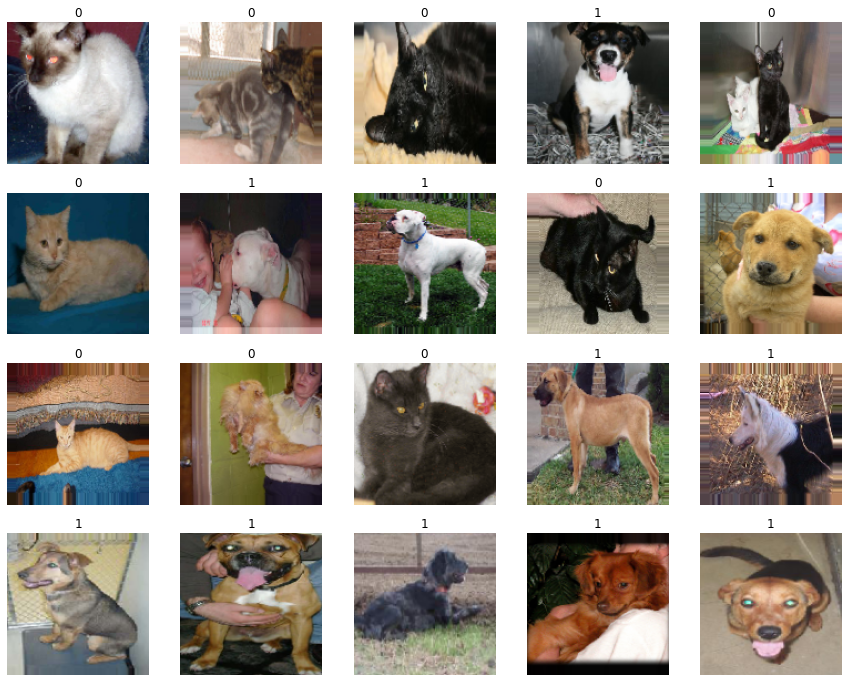

In [10]:
# for x_data, t_data in train_generator:
#     print(x_data.shape)  # (20, 128, 128, 3)
#     print(type(x_data))  # <class 'numpy.ndarray'>
#     print(t_data)        # [0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0.]
#     # 0 : 고양이,  1 : 댕댕이
#     break

# 2. Display images in the batch
fig = plt.figure(figsize=(15, 12))
# axs = []
for x_data, t_data in train_generator:
    print(x_data.shape)  # (20, 128, 128, 3)
    print(type(x_data))  # <class 'numpy.ndarray'>
    print(t_data)        # [0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0.]
    # 0 : 고양이,  1 : 댕댕이
    for idx, img in enumerate(x_data):
        ax = plt.subplot(4, 5, idx + 1)
        # axs.append(fig.add_subplot(4,5,idx+1))
        plt.imshow(img)
        plt.title("{}".format(str(int(t_data[idx]))))
        plt.axis("off")
    break
plt.show()

## Model : CNN + FCN

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(128,128,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))   # units=2 for softmax

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 512)               2

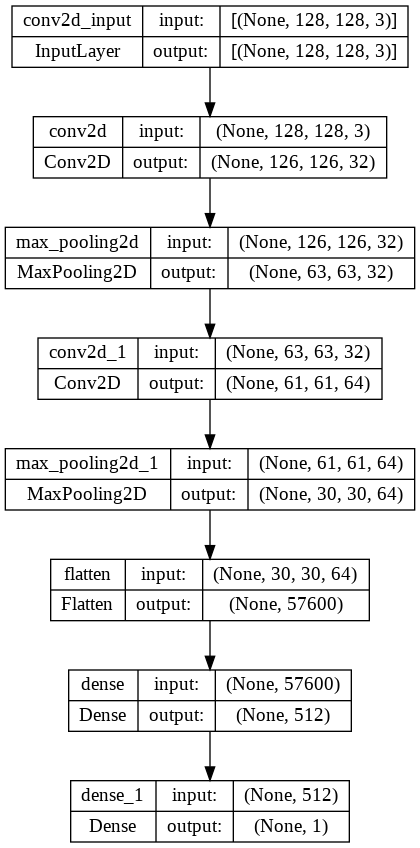

In [12]:
from tensorflow import keras
keras.utils.plot_model(model, show_shapes=True)

In [13]:
len(train_generator),len(test_generator)

(100, 10)

In [14]:
######################################################
# Training model using augmentated data
######################################################
#
%%time
history = model.fit(
    train_generator, 
    epochs=30,  # 30, 50, 100
    steps_per_epoch = 100, # len(train_generator)
    validation_data=test_generator, 
    validation_steps=10) # len(test_generator)


Epoch 1/30
100/100 [==============================] - 25s 147ms/step - loss: 0.7980 - accuracy: 0.5600 - val_loss: 0.6723 - val_accuracy: 0.6400
Epoch 2/30
100/100 [==============================] - 15s 145ms/step - loss: 0.6798 - accuracy: 0.5790 - val_loss: 0.6886 - val_accuracy: 0.5900
Epoch 3/30
100/100 [==============================] - 14s 144ms/step - loss: 0.6675 - accuracy: 0.5940 - val_loss: 0.6551 - val_accuracy: 0.6300
Epoch 4/30
100/100 [==============================] - 14s 145ms/step - loss: 0.6437 - accuracy: 0.6330 - val_loss: 0.6522 - val_accuracy: 0.6500
Epoch 5/30
100/100 [==============================] - 14s 145ms/step - loss: 0.6257 - accuracy: 0.6735 - val_loss: 0.6225 - val_accuracy: 0.6700
Epoch 6/30
100/100 [==============================] - 14s 144ms/step - loss: 0.5776 - accuracy: 0.6925 - val_loss: 0.6408 - val_accuracy: 0.6950
Epoch 7/30
100/100 [==============================] - 14s 144ms/step - loss: 0.5769 - accuracy: 0.7015 - val_loss: 0.6643 - val_ac

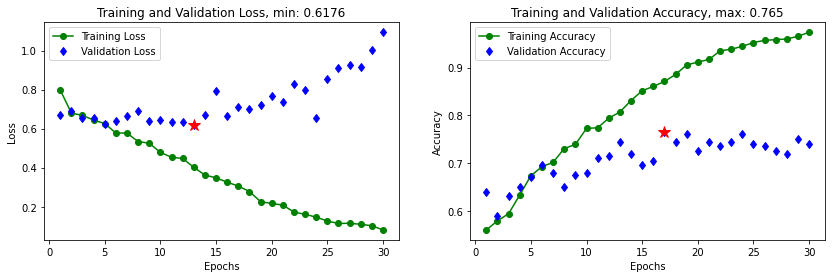

In [15]:
#############################################
# More training graphs
# More graphs of loss and accuracy
# import matplotlib.pyplot as plt
import numpy as np

history_dict = history.history 
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],4)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],4)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Overfitted!

---

In [16]:
len(train_generator),len(test_generator)

(100, 10)

In [17]:
model.evaluate(test_generator)

10/10 [==============================] - 1s 67ms/step - loss: 1.0936 - accuracy: 0.7400


[1.0936466455459595, 0.7400000095367432]

In [18]:
pred = model.predict(test_generator)

10/10 [==============================] - 1s 64ms/step


In [19]:
pred.shape,pred[:10]

((200, 1), array([[1.0000000e+00],
        [3.7458441e-03],
        [1.8531927e-01],
        [3.1495567e-02],
        [2.1284789e-01],
        [8.9182794e-07],
        [4.3241864e-01],
        [1.2054809e-01],
        [9.5092708e-01],
        [9.9999154e-01]], dtype=float32))

In [20]:
for x_data, t_data in test_generator:
    print(x_data.shape, t_data.shape)  # (20, 128, 128, 3)
    print(type(x_data))  # <class 'numpy.ndarray'>
    print(t_data)        # [0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0.]
    # 0 : 고양이,  1 : 댕댕이
    break

(20, 128, 128, 3) (20,)
<class 'numpy.ndarray'>
[1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]


In [21]:
y_test = []
y_pred = []

for x_data, t_data in test_generator:
    # print(x_data.shape, t_data.shape)  # (20, 128, 128, 3)
    y_pred0=model.predict(x_data, verbose=0)
    # print(np.round(y_pred0))
    y_pred.append(np.round(np.ndarray.flatten(y_pred0)).tolist())
    # print(type(x_data))  # <class 'numpy.ndarray'>
    # print(t_data)        # [0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0.]
    y_test.append(t_data.tolist())
    # 0 : 고양이,  1 : 댕댕이
    if len(y_test)==len(test_generator):
        break

# Testing code
# np.round(np.ndarray.flatten(y_pred0)).tolist()
# t_data.tolist()
print(len(y_test),len(y_pred))

# Flatten the list of list of a batch
y_test = [ item for elem in y_test for item in elem]
y_pred = [ item for elem in y_pred for item in elem]

print(len(y_test),len(y_pred))  # Success!!!

10 10
200 200


## CONFUSION MATRIX

In [22]:
# Correct-handling with tf_dataset - test_data,unbatch()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

confusion_matrix(y_test, y_pred)

0.745


array([[73, 22],
       [29, 76]])

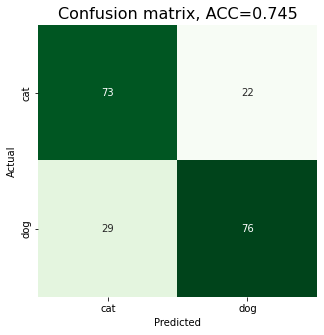

In [23]:
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
names = ['cat', 'dog']

import seaborn as sns
plt.figure(figsize=(5,5))
sns.heatmap(cm, cbar=False, xticklabels=names, yticklabels=names, fmt='d', annot=True, cmap=plt.cm.Greens) #coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix, ACC={acc}', fontsize=16)
plt.show()